In [28]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Upload the file
uploaded = files.upload()

Saving housing.csv to housing.csv


In [3]:
housing = pd.read_csv('housing.csv')

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# Create income category for visualisation purposes
housing_cat = housing.copy()
housing_cat["income_cat"] = pd.cut(housing_cat["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

<Axes: >

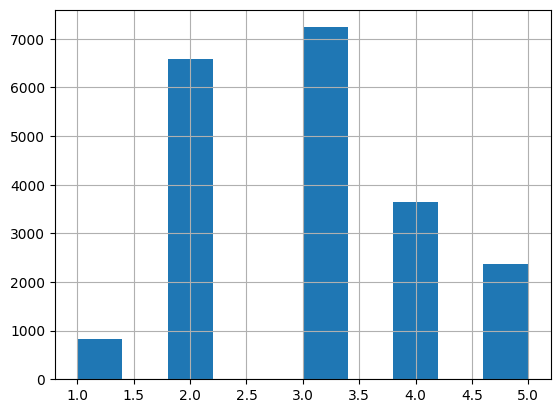

In [5]:
housing_cat["income_cat"].hist()

In [6]:
# Find null values in the dataset
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
# Drop null values in the total bedrooms column
housing = housing.dropna(subset=['total_bedrooms'])

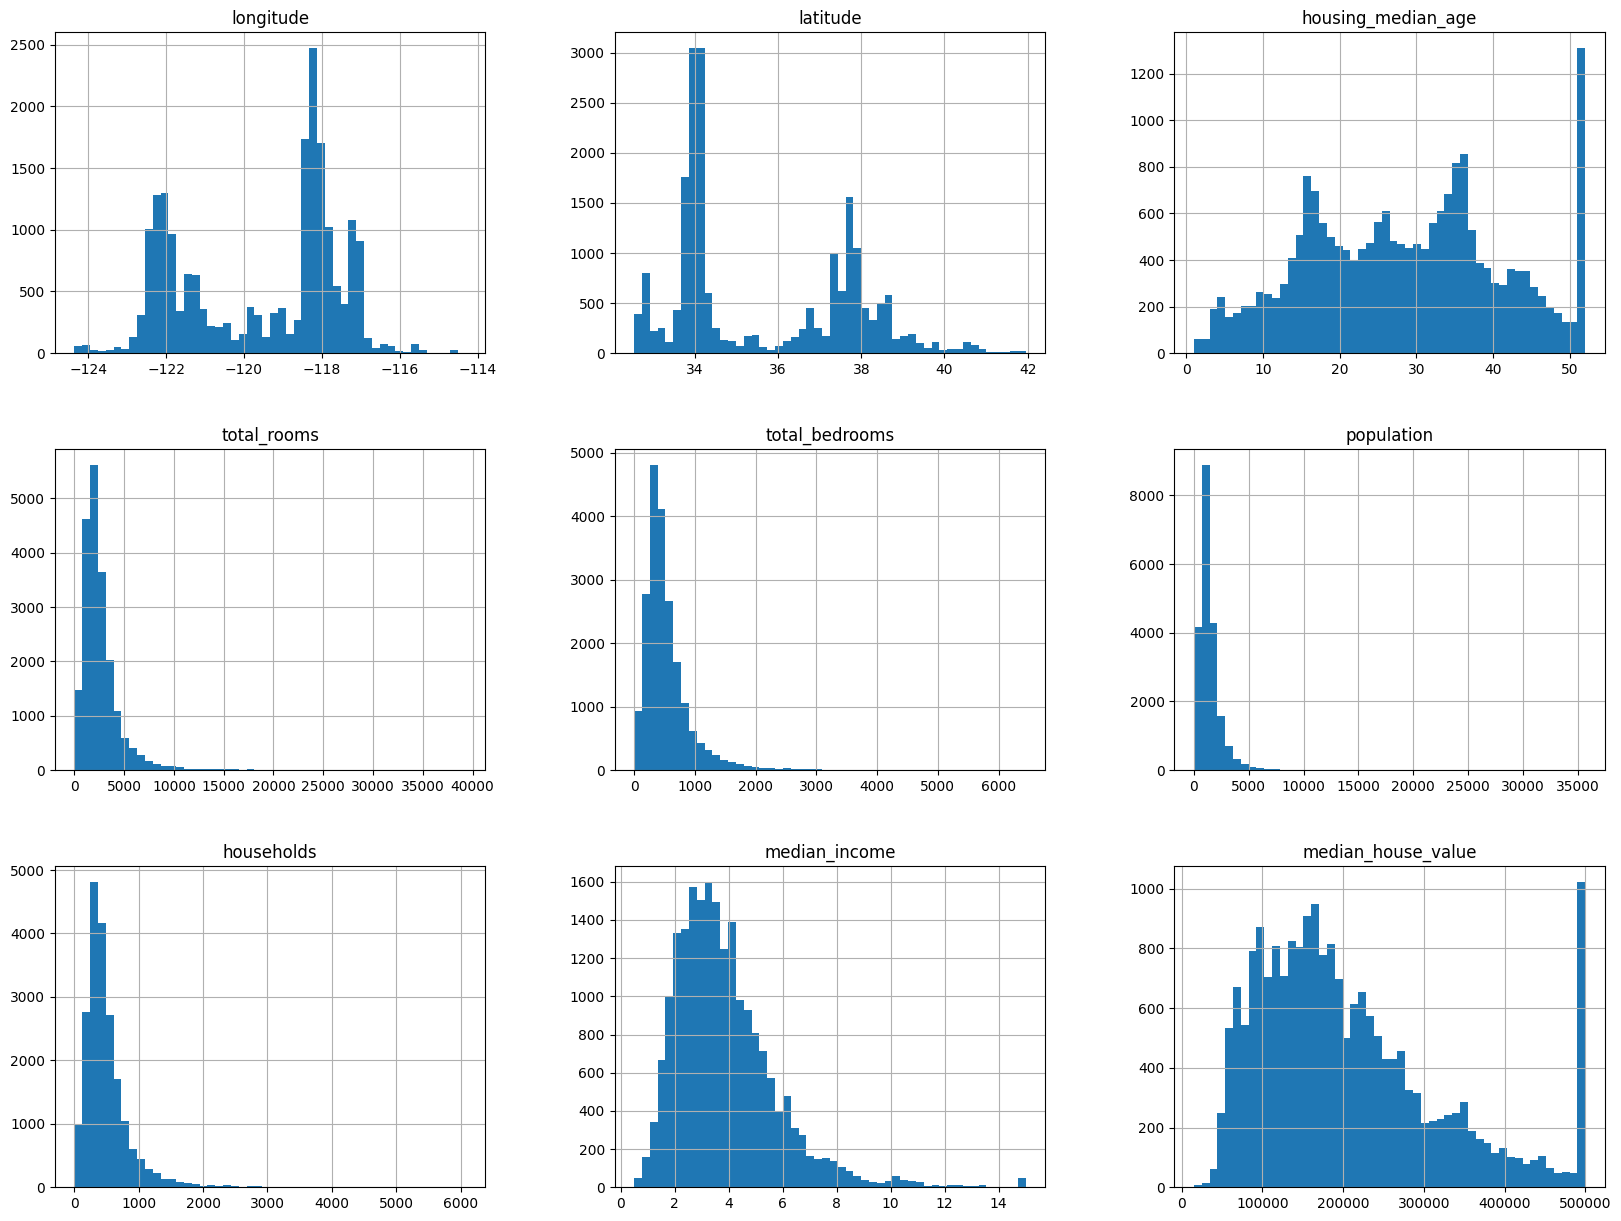

In [8]:
# Plotting the different columns in order to have a visual representation of their distribution
%matplotlib inline
housing.hist(bins=50, figsize=(20,15))
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

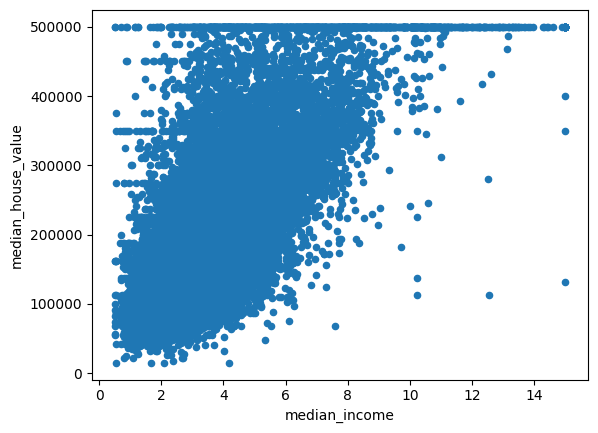

In [9]:
# Identifying a upper ceiling for the median house value of 500001
housing.plot(kind='scatter', x='median_income', y='median_house_value')

In [10]:
# Drop rows with a median house value of 500001
housing = housing[housing['median_house_value'] != 500001]

In [11]:
# Create a function to split the data into training and test sets
def split_train_test(data, test_ratio):
    train_set, test_set = train_test_split(data, test_size=test_ratio, random_state=29)
    return train_set, test_set

# Split the data into training and test sets
train_set, test_set = split_train_test(housing, 0.2)

# Copy the training set for further processing
housing_copy = train_set.copy()

# Define the target labels for the training set
train_set_labels = train_set['median_house_value'].copy()

# Create a function to check if a data instance should be in the test set
def test_set_check(identifier, test_ratio):
    hashed_identifier = crc32(np.int64(identifier)) & 0xffffffff
    return hashed_identifier < test_ratio * 2**32

In [12]:
def split_train_test_by_id(data, test_ratio, id_column):
  # We use unique identifier id_column to decide whether each row goes to test set or training set 
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  # This ensures that the test set will remain consistent across multiple runs without any previous entry from the training set
  return data.loc[~in_test_set], data.loc[in_test_set]
  
# Add an index column to the housing data
housing_with_id = housing.reset_index()

# Split the data into training and test sets using the index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

# Create income category for visualization purposes
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

# Split the data into train/test sets using StratifiedShuffleSplit to ensure same class proportions
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=29)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.iloc[train_index]
    strat_test_set = housing.iloc[test_index]

<ipython-input-12-5d7cc66a90f1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])


In [13]:
corr_matrix = housing.corr()
housing.corr(numeric_only = True)

<ipython-input-13-8fcf6fee8162>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924092,-0.103793,0.045081,0.069871,0.101488,0.056784,-0.009157,-0.046187
latitude,-0.924092,1.000000,0.007494,-0.033861,-0.067940,-0.113535,-0.073439,-0.077999,-0.148637
housing_median_age,-0.103793,0.007494,1.000000,-0.371274,-0.327308,-0.294553,-0.309135,-0.194259,0.068595
total_rooms,0.045081,-0.033861,-0.371274,1.000000,0.934147,0.859717,0.921620,0.223865,0.142188
total_bedrooms,0.069871,-0.067940,-0.327308,0.934147,1.000000,0.879176,0.979144,0.021903,0.074672
population,0.101488,-0.113535,-0.294553,0.859717,0.879176,1.000000,0.908940,0.042522,0.011153
households,0.056784,-0.073439,-0.309135,0.921620,0.979144,0.908940,1.000000,0.046430,0.093890
median_income,-0.009157,-0.077999,-0.194259,0.223865,0.021903,0.042522,0.046430,1.000000,0.642733
median_house_value,-0.046187,-0.148637,0.068595,0.142188,0.074672,0.011153,0.093890,0.642733,1.000000


<ipython-input-14-ca67141b0a26>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  housing_corr_matrix = housing.corr()


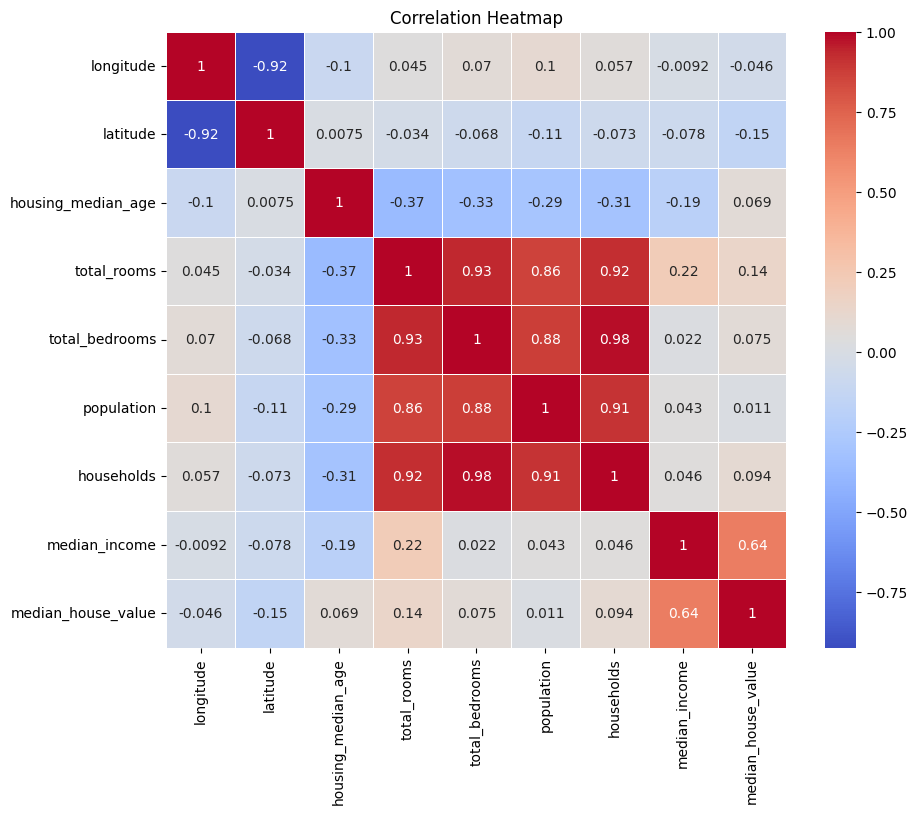

In [14]:
housing_corr_matrix = housing.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(housing_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

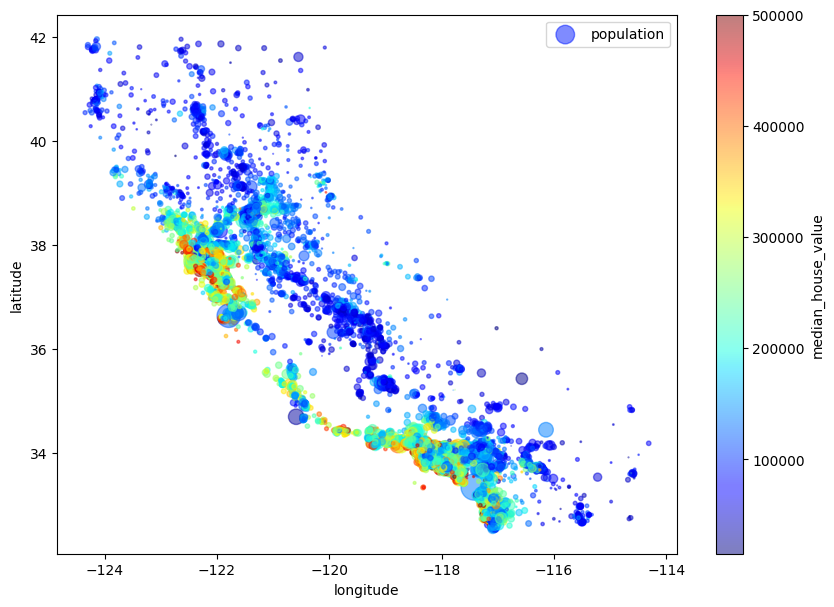

In [16]:
# Discover and visualize the data
housing = strat_train_set.copy()

# Visualize geographical data
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
             s=housing["population"]/100, label="population", figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

<Axes: xlabel='longitude', ylabel='latitude'>

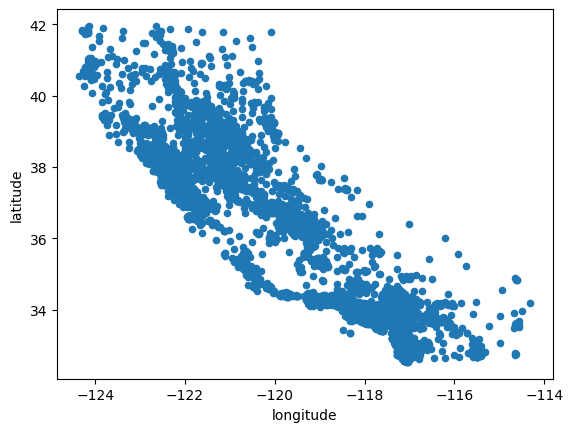

In [17]:
# Visualising geographical data
housing.plot(kind="scatter", x="longitude", y="latitude")

In [18]:
# Preparing the data for machine learning algorithms
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
housing = housing.dropna(subset=["total_bedrooms"])

In [19]:
# Transformation pipelines
# Defining the numerical data pipeline, which includes two steps:
# 1) 'imputer': Filling in missing values using the median strategy
# 2) 'std_scaler': Scaling features using standardization
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

# Applying the numerical pipeline to the numerical features in 'housing' DataFrame
num_attribs = list(housing.select_dtypes(include=[np.number]))
cat_attribs = ["ocean_proximity"]

# Setting up the full pipeline, which applies the numerical pipeline to the numerical attributes 
# and applies a one-hot encoding to the categorical attributes
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

# Applying the full pipeline to the 'housing' DataFrame
housing_prepared = full_pipeline.fit_transform(housing)

# Train Models:

In [20]:
# Select and train the different models
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

xgb_reg = XGBRegressor()
xgb_reg.fit(housing_prepared, housing_labels)

# Evaluate the models using cross-validation
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# Decision Trees

# Linear Regression

In [32]:
# Computing the r squared for Linear Regression preddictions
lin_reg_predictions = lin_reg.predict(housing_prepared)
r2 = r2_score(housing_labels, lin_reg_predictions)
r2

0.6165888906844228

In [28]:
# Performing K-fold cross-validation with K=10.
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
# Calculating the Root Mean Squared Error (RMSE) between the predictions and the true values
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [57949.38069005 62736.44264346 60814.0287442  59512.08044192
 57422.81841545 59309.98928756 60342.44200339 63452.85196969
 62572.79239507 60840.40802618]
Mean: 60495.32346169868
Standard deviation: 1913.723913778658


# Decision Trees

In [26]:
# Performing K-fold cross-validation with K=10.
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                              scoring="neg_mean_squared_error", cv=10)
# Calculating the Root Mean Squared Error (RMSE) between the predictions and the true values
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [63183.42940173 67193.17108197 63036.50373358 59396.22446541
 61661.89389874 62472.58212472 65978.80222274 66342.74023316
 65357.6019516  64250.28173842]
Mean: 63887.32308520656
Standard deviation: 2279.6666863491887


# RandomForestRegressor

In [43]:
# Performing K-fold cross-validation with K=10.
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring='neg_mean_squared_error', cv=10)
# Calculating the Root Mean Squared Error (RMSE) between the predictions and the true values
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [43431.24067431 45569.96730746 43605.21993064 44788.85491004
 43446.17182634 42314.55142157 45351.08090814 47218.78766757
 47718.22792668 45478.42864201]
Mean: 44892.25312147676
Standard deviation: 1641.6369254936699


# XGBoost

In [51]:
# Performing K-fold cross-validation with K=10.
xgb_scores = cross_val_score(xgb_reg, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=10)
# Calculating the Root Mean Squared Error (RMSE) between the predictions and the true values
xgb_rmse_scores = np.sqrt(-xgb_scores)
display_scores(xgb_rmse_scores)

Scores: [41773.13121219 43360.90889854 41762.88868175 42298.85463109
 41811.57325013 41508.97823511 43797.77564035 46329.16020197
 45534.94061321 44636.92128689]
Mean: 43281.51326512307
Standard deviation: 1653.0489161276673


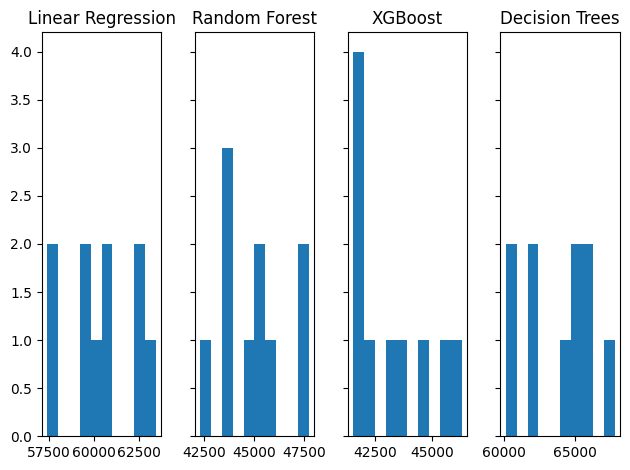

In [54]:
# Plotting histograms
fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)
n_bins = 10
axs[0].hist(lin_rmse_scores, bins=n_bins)
axs[0].set_title("Linear Regression")
axs[1].hist(forest_rmse_scores, bins=n_bins)
axs[1].set_title("Random Forest")
axs[2].hist(xgb_rmse_scores, bins=n_bins)
axs[2].set_title("XGBoost")
axs[3].hist(tree_rmse_scores, bins=n_bins)
axs[3].set_title("Decision Trees")
plt.show()